<a href="https://colab.research.google.com/github/AilingLiu/Inferential_Statistics/blob/master/Inferential_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook summarizes the testing methods from <b>Inferential Statitistics </b> course taught by <u>University of Amsterdam</u> on [Coursera](https://www.coursera.org/learn/inferential-statistics). The course had taught how to conduct statistical test usng R. Here, I am using Python to do the test. All the formulas used in this document can be found [here](https://github.com/AilingLiu/Inferential_Statistics/blob/master/FormulasTables.pdf).

In [0]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm

# Compare Two Groups

<b>Construct Hypotheses</b>

When we are testing between two competing hypotheses, a null hypothesis $H_0$ and an alternative hypothesis $H_1$, we generally assume that the null hypothesis is true unless the data shows a strong indication that this is not the case. 

By doing hypotheses testing, we <u>test the probability of finding a sample statistic given that the null hypothesis is true</u>. If the null hypothesis is true, the difference between a sample statistics and the population parameter is <b>due to sampling error</b>, that is, fluctuations in the sample from the population. However, **if the probability of finding a sample statistic as extreme as ours under the null hypothesis is very small, we generally reject the null hypothesis**.

> Test your understanding:


1.   Imagine we have found a p value of 0.30 called p1 and another p value of 0.02 called p2, do these p values indicate strong evidence or weak evidence in favour of the null hypothesis? 
>> Answer: p1 indicates strong evidence in favour of the null hypothesis; p2 indicates weak evidence in favour of the null hypothesis.
2.   What does a p value of 0.20 mean?
>> Answer: A p value of 0.20 means that there's a probability of 20% of obtaining a similar result or more extreme given that the null hypothesis is true



## Z test to compare two proportions from independent samples


We usually calculate two things:

1.   The difference between two sample proportions
2.   The standard error

> Example
<br>In this exercise we have a sample of 100 males with a proportion of left wing voters of 0.6 and a sample of 150 females with a proportion of left-wing voters of 0.42. 

In [0]:
nmale=100
nfemale=150
malep=0.6
femalep=0.42

#pooled proportion
poolp=(nmale*malep+nfemale*femalep)/(nmale+nfemale)

#standard error under the null hypothesis
se=np.sqrt(poolp*(1-poolp)*(1/nmale + 1/nfemale))

#z calculated value
z_val = (malep - femalep)/se

#corresponding p value
p_val = (1-st.norm.cdf(z_val))*2

sig = 0.05
if p_val <=sig:
  conclusion='Rejected'
else:
  conclusion='Not enough evidence to reject'

print(f'Calculated Z value: {z_val:.4f}\nPvalue is: {p_val:.4f} \nConclusion on Null Hypothesis given {sig} significance level: {conclusion}')

Calculated Z value: 2.7889
Pvalue is: 0.0053 
Conclusion on Null Hypothesis given 0.05 significance level: Rejected


Another way to conduct the test is to get the confidence interval of the difference from the two proportions. If 0 (null hypothesis) falls inside the interval, we will reject null hypotheseis. We need two parameters to conduct this test:

1.   The z score corresponding to the selected confidence level: $(1-conf)/2$.
2.   The standarad error for the difference between two proportions

In [0]:
#z score under given confidence level
sig=0.01
z_score = np.abs(st.norm.ppf(sig/2))

# standard error for the difference
sep=np.sqrt(malep*(1-malep)/nmale + femalep*(1-femalep)/nfemale)

#lower bound of confidence interval
lb = (malep-femalep) - z_score*sep
#upper bound of confidence interval
ub = (malep-femalep) + z_score*sep

print(f'{(1-sig)*100} percent confidence interval:\n[{lb:.4f}, {ub:.4f}]')

99.0 percent confidence interval:
[0.0166, 0.3434]


There are differences and these differences are significant because the 99% confidence interval does not contain 0.

The equivalent z test for two independent proportions is [proportions_ztest](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html).

In [0]:
#equivalent in python

from statsmodels.stats.proportion import proportions_ztest
x_success = np.array([nmale*malep, nfemale*femalep])
n_total = np.array([nmale, nfemale])
z_val, p_val = proportions_ztest(count=x_success, nobs=n_total, alternative='two-sided')

#make a function to give conclusion directly based on pvalue and significance level
def testeval(sig, pval):
  
  """
  Conclusion of rejection status on null hypothesis given significance level
  and the pvalue corresponding to calculated test statistic.

  Parameters
  ----------
  sig: float
    Significance level. Governs the chance of a false positive.
      A significance level of 0.05 means that there is a 5% chance of
      a false positive.
  
  pval: float
    Calculated p value. The probability of obtaining a similar results
    or more extreme given null hypothesis is true.
  
  Returns:
  --------
  result: string
    Conclusion of rejection status on null hypothesis.
  """

  if pval <=sig:
    result = 'Rejected'
  else:
    result = 'Not enough evidence to reject'
  return result

siglevel = 0.05
conclusion = testeval(siglevel, p_val)
print(f'Calculated Z value: {z_val:.4f}\nPvalue is: {p_val:.4f} \nConclusion on Null Hypothesis given {siglevel} significance level: {conclusion}\n')

siglevel = 0.01
conclusion = testeval(siglevel, p_val)
print(f'Calculated Z value: {z_val:.4f}\nPvalue is: {p_val:.4f} \nConclusion on Null Hypothesis given {siglevel} significance level: {conclusion}\n')

def prop_confint_2ind(count, nobs, alpha=0.05):
  
  """
  A/B test for two proportions;
  given a success a trial size of group A and B compute
  its confidence interval;
  resulting confidence interval matches R's prop.test function

  Parameters
  ----------
  count: array
      Number of successes in each group

  nobs: array
      Size, or number of observations in each group

  alpha : float, default 0.05
      Significance level. Governs the chance of a false positive.
      A significance level of 0.05 means that there is a 5% chance of
      a false positive. In other words, our confidence level is
      1 - 0.05 = 0.95

  Returns
  -------
  prop_diff : float
      Difference between the two proportion

  confint : 1d ndarray
      Confidence interval of the two proportion test
  """  

  a_success, b_success = count[0], count[1]
  a_size, b_size = nobs[0], nobs[1]
  a_prop, b_prop = a_success/a_size, b_success/b_size
  prop_diff = a_prop-b_prop

  #z score under given confidence level
  z_score = np.abs(st.norm.ppf(alpha/2))

  # standard error for the difference
  sep=np.sqrt(a_prop*(1-a_prop)/a_size + b_prop*(1-b_prop)/b_size)

  #lower bound of confidence interval
  lb = prop_diff - z_score*sep
  #upper bound of confidence interval
  ub = prop_diff + z_score*sep
  return prop_diff, [lb, ub]

sig=0.01
diff, [lowerb, upperb] = prop_confint_2ind(count=x_success, nobs=n_total, alpha=sig)
print(f'{(1-sig)*100} percent confidence interval:\n[{lowerb:.4f}, {upperb:.4f}]')

Calculated Z value: 2.7889
Pvalue is: 0.0053 
Conclusion on Null Hypothesis given 0.05 significance level: Rejected

Calculated Z value: 2.7889
Pvalue is: 0.0053 
Conclusion on Null Hypothesis given 0.01 significance level: Rejected

99.0 percent confidence interval:
[0.0166, 0.3434]


## T test to compare compare two means from independent samples

we usually calculate 2 other things first

1.   The difference between two independent sample means
2.   The standard error of the difference between two independent sample means

> Example
<br>In this exercise we have a sample of 100 males that do sports on average 4.2 hours per week and a sample of 150 females that do sports on average 5.8 hours per week. 
*  Case a: the population variances are unequal in two groups
*  Case b: the populatin variances are equal in two groups

In [0]:
#Case a: the population variances are unequal
nmale=100
malemean=4.2
stdmale=2.3
nfemale=150
femalemean=5.8
stdfemale=3.1

#standard eror for the difference between two means
se=np.sqrt(stdmale**2/nmale+stdfemale**2/nfemale)

#mean difference
diff=malemean-femalemean

#t value
t_val=diff/se

#degree of freedom
df=se**2/((1/(nmale-1)*(stdmale**2/nmale)**2)+(1/(nfemale-1)*(stdfemale**2/nfemale)**2))

#calculate the p value
pval=(1-st.t.cdf(np.abs(t_val), df))*2
siglevel=0.01
conclusion=testeval(siglevel, pval)
print(f'Calculated T value: {t_val:.4f}\nPvalue is: {pval:.4f} \nConclusion on Null Hypothesis given {siglevel} significance level: {conclusion}\n')

# calculate the 99% confidence interval
t_score=np.abs(st.t.ppf(siglevel/2, df))
lb = diff-t_score*(se)
ub = diff+t_score*(se)
print(f'{(1-siglevel)*100} percent confidence interval:\n[{lb:.4f}, {ub:.4f}]')


Calculated T value: -4.6783
Pvalue is: 0.0000 
Conclusion on Null Hypothesis given 0.01 significance level: Rejected

99.0 percent confidence interval:
[-2.4817, -0.7183]


In [0]:
#Case b: the population variances are equal
nmale=100
malemean=4.2
nfemale=150
femalemean=5.8
std=2.8

#mean difference
diff=malemean-femalemean

#pooled standard deviation
s=np.sqrt(((nmale-1)*std**2 + (nfemale-1)*std**2)/(nmale-1+nfemale-1))

#standard eror for the difference between two means
se=s*np.sqrt(1/nmale+1/nfemale)

#t value
t_val=diff/se

#degree of freedom
df=nmale+nfemale-2

#calculate the p value
pval=(1-st.t.cdf(np.abs(t_val), df))*2
siglevel=0.01
conclusion=testeval(siglevel, pval)
print(f'Calculated T value: {t_val:.4f}\nPvalue is: {pval:.4f} \nConclusion on Null Hypothesis given {siglevel} significance level: {conclusion}\n')

# calculate the 99% confidence interval
t_score=np.abs(st.t.ppf(siglevel/2, df))
lb = diff-t_score*(se)
ub = diff+t_score*(se)
print(f'{(1-siglevel)*100} percent confidence interval:\n[{lb:.4f}, {ub:.4f}]')


Calculated T value: -4.4263
Pvalue is: 0.0000 
Conclusion on Null Hypothesis given 0.01 significance level: Rejected

99.0 percent confidence interval:
[-2.5383, -0.6617]


Equivalent t test for two independent is [ttest_ind](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ttest_ind.html) from scipy or [ttest_ind](https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html) from statsmodels. Both methods take data points as array directly, without specifically giving mean, standard deviation, or size.

In [0]:
from statsmodels.stats.weightstats import ttest_ind

#generate random data with mean, std, size as above sample.
## equal variance
rvmale=np.random.normal(loc=malemean, scale=std, size=nmale)
rvmale_fix = (rvmale - np.mean(rvmale)) * (std / np.std(rvmale)) + malemean #fix mean problem
rvfemale=np.random.normal(loc=femalemean, scale=std, size=nfemale)
rvfemale_fix = (rvfemale - np.mean(rvfemale)) * (std / np.std(rvfemale)) + femalemean #fix mean problem

t_val, pval, df=ttest_ind(rvmale_fix, rvfemale_fix, alternative='two-sided', usevar='pooled', value=0)
conclusion=testeval(0.01, pval)
print(f'Calculated T value: {t_val:.4f}\nPvalue is: {pval:.4f} \nConclusion on Null Hypothesis given {0.01} significance level: {conclusion}\n')

Calculated T value: -4.4085
Pvalue is: 0.0000 
Conclusion on Null Hypothesis given 0.01 significance level: Rejected



In [0]:
## unequal variance
rvmale=np.random.normal(loc=malemean, scale=stdmale, size=nmale)
rvmale_fix = (rvmale - np.mean(rvmale)) * (stdmale / np.std(rvmale)) + malemean #fix mean problem
rvfemale=np.random.normal(loc=femalemean, scale=stdfemale, size=nfemale)
rvfemale_fix = (rvfemale - np.mean(rvfemale)) * (stdfemale / np.std(rvfemale)) + femalemean #fix mean problem

t_val, pval, df=ttest_ind(rvmale_fix, rvfemale_fix, alternative='two-sided', usevar='unequal', value=0)
conclusion=testeval(0.01, pval)
print(f'Calculated T value: {t_val:.4f}\nPvalue is: {pval:.4f} \nConclusion on Null Hypothesis given {0.01} significance level: {conclusion}\n')

Calculated T value: -4.6591
Pvalue is: 0.0000 
Conclusion on Null Hypothesis given 0.01 significance level: Rejected



How to interpret the result?

Given that the null hypothesis is true, there is a probability of 0.000005 (5.21345e-06) of obtaining a result equally or more extreme. We are 99% confident that the population difference in hours of sport per week between males and females is between -2.4817 and -0.7183 hours per week.

## Comparing two proportions for paired sample - McNemar's Test

Working with dependent data, such as twins, couples, same subject from different time, we will need to use different methods from above.

> Example
<br> Our research question here is whether there is a difference between the proportion of surveyed individuals that approve of the European union and the proportion of their partners that approve of the European union. What would be a good pair of hypotheses?
<br>Answer
<br>$H_0$: The proportion of EU approval is not different in surveyed individuals and their partners. $H_1$: The proportion of EU approval is different in surveyed individuals and their partners

In [0]:
import pandas as pd

col_index=pd.MultiIndex.from_tuples([('Partner Approves of the EU', 'Yes'), ('Partner Approves of the EU', 'No')])
row_index=pd.MultiIndex.from_tuples([('Survey Individuals that approve of the EU', 'Yes'),('Survey Individuals that approve of the EU', 'No')])
survey = pd.DataFrame(np.array([[150, 50], [35, 100]]), index=row_index, columns=col_index)
survey['row_totals'] = survey.sum(axis=1)
s=survey.sum(axis=0)
s.name='column_totals'
survey = survey.append(s)
display(survey)

Partner Approves of the EU  ... row_totals
                                                                        Yes  ...           
(Survey Individuals that approve of the EU, Yes)                        150  ...        200
(Survey Individuals that approve of the EU, No)                          35  ...        135
column_totals                                                           185  ...        335

[3 rows x 3 columns]

In [0]:
#calculate z value
z_val=(50-35)/np.sqrt(50+35)

#get pvalue
pval=(1-st.norm.cdf(np.abs(z_val)))*2
siglevel=0.05
conclusion=testeval(siglevel, pval)
print(f'Calculated Z value: {z_val:.4f}\nPvalue is: {pval:.4f} \nConclusion on Null Hypothesis given {siglevel} significance level: {conclusion}\n')

Calculated Z value: 1.6270
Pvalue is: 0.1037 
Conclusion on Null Hypothesis given 0.05 significance level: Not enough evidence to reject



The equivalent [mcnemar's test](http://www.statsmodels.org/dev/generated/statsmodels.stats.contingency_tables.mcnemar.html) in statsmodelss.

In [0]:
from statsmodels.stats.contingency_tables import mcnemar
result = mcnemar(survey.iloc[:2, :2].to_numpy(), exact=False, correction=False)
print(result)

pvalue      0.1037416782365415
statistic   2.6470588235294117


## Compare two means for paired samples

> Example
<br>An example when we would do this is if we would want to know the effectiveness of a diet on people's weight. Our research question here is whether the diet that we have invented leads to a reduction in weight. As such our research question is directional. What would be a good set of hypotheses?
<br>Answer: 
<br>$H_0$: There is no difference in people's weight before and after the diet. $H_1$: There is a reduction in weight after taking the diet.

In [0]:
#generate data
pre_weight=np.random.normal(loc=81.53587, scale=8.113578, size=100)
pre_weight_fix=(pre_weight-np.mean(pre_weight))*(8.113578/np.std(pre_weight))+81.5358

post_weight=np.random.normal(loc=78.20945, scale=9.223542, size=100)
post_weight_fix=(post_weight-np.mean(post_weight))*(9.223542/np.std(pre_weight))+78.20945

# get the difference of the two means
diff = pre_weight_fix.mean()-post_weight_fix.mean()

#standard deviation of the differences
stddiff = np.std(pre_weight_fix-post_weight_fix)

#standard error of the difference
se=stddiff/np.sqrt(100)

tval=diff/se 
pval=(1-st.t.cdf(np.abs(tval), 100-1))*2
siglevel=0.05
conclusion=testeval(siglevel, pval)
print(f'Calculated t value: {tval:.4f}\nPvalue is: {pval:.4f} \nConclusion on Null Hypothesis given {siglevel} significance level: {conclusion}\n')

Calculated t value: 2.3788
Pvalue is: 0.0193 
Conclusion on Null Hypothesis given 0.05 significance level: Rejected



# Categorical Association

## Chi-square

We would like to find the association between two categorical varianbes. In below example, we are an advertisement company that have collected data coming from three different groups: Student, Parent, and Corporate. We are interested to know which ad type interests which group, so we can invest corresponding ads in those groups. Below data shows votes from different audience groups on their favorite ads: Party, Child, Office. 

To be specific, we need to find out two things:
1.   Is the ad type has any association with audience group?
2.   If there's association, which audience is in favor of which ad type?

In [0]:
data = pd.DataFrame(np.array([[12, 5, 6],[7, 15, 7],[5, 5, 14]]), columns=['Party', 'Child', 'Office'], index=['Student', 'Parent', 'Corporate'])
display(data)

,Party,Child,Office
Student,12,5,6
Parent,7,15,7
Corporate,5,5,14


We can conduct chi-square test to test the association between two categorical variables using scipy modules.

In [0]:
from scipy.stats import chi2_contingency

c_stat, pval, df, expected_val = chi2_contingency(data)
expected_val = expected_val.round(1)

print('Expected Value if these two categorical varianbles are not related:')
display(expected_val)

print('Calculated P value: {}'.format(pval))

Expected Value if these two categorical varianbles are not related:


array([[ 7.3,  7.6,  8.2],
       [ 9.2,  9.5, 10.3],
       [ 7.6,  7.9,  8.5]])

Calculated P value: 0.005408290803578588


Here we can see that the expected values are far off from the observed data. Moreover, there are only 0.5% chance to observe such data if audience group has nothing to do with advertisement type. Hene, we rejected the null hypothesis in favor of the alternative hypothesis, i.e. the audience group has preference on their ad type. 

But how strong is this association? We can use Cramer's V to check its strength, where 0 means no association, and 1 is perfect. 

In [0]:
n=data.sum().sum() #the total number of observation
m=min(data.shape)-1 #either the number of rows or columns whichever the smallest - 1
cramerV=np.sqrt(c_stat/(n*m))
print(cramerV)

0.3107928316933293


Cramers V is about 0.31, which is pretty modest.

But which ads is preferred or least preferred by each audience group? We can use standard residusals to see where there is the most deviation from the expected values.

To standardise our residuals we need to divide each residual value by its standard error. We can directly get this value by using statsmodel api.

In [0]:
import statsmodels.api as sm
# need to make a contingency table format
table = sm.stats.Table(data)

#standardized residuals
table.standardized_resids

,Party,Child,Office
Student,2.544487,-1.363592,-1.132685
Parent,-1.096214,2.744428,-1.629494
Corporate,-1.369141,-1.520432,2.822363


From this you can see that the biggest values are for the student + party cell, parent + child cell and the corporate + office cell.

## Chi-square goodness of fit

Your null hypothesis is that 60% of college students go to parties regularly, 30% go occaisionally and 10% never go. You want to test if your observed data matched this proportions. The solution of this question will be very similar to the above question. The difference will be you will need to calculate the expected counts based on the expected proportions listed in null hypothesis.

In [0]:
exp_p=np.array([0.6, 0.3, 0.1]) #expected proportions
exp_count=data.loc['Student'].sum()*exp_p
display(pd.DataFrame([exp_count, data.loc['Student']], index=['expected', 'observed'], columns=data.columns))


,Party,Child,Office
expected,13.8,6.9,2.3
observed,12.0,5.0,6.0


We can see that `Office` group deviates the most from expected values. We will be using [chisqure](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html) to get test statistic and p value.

In [0]:
from scipy.stats import chisquare
c_stat, pval = chisquare(data.loc['Student'], f_exp=exp_count)
print(f'chi square: {c_stat:.4f}\n p value: {pval:.4f}')

chi square: 6.7101
 p value: 0.0349


As the calculated p value is smaller than 0.05 significance level, we rejected the null hypothesis. It means college students in our sample differed from the expected distribution.

## Fisher's Exact Test

One of the assumption for chi-squre test is the minimum count in each cell is 5. When this assumption is not met, we can use Fisher's Exact Test to check two categorical variables' association.

Fisher's exact test compares the observed values to a probability distribution. We find this comparison distribution by examining all possible rearrangements of our table. The restrictions are that the marginal frequencies must be the same.

> Example
<br>You had expected that parents would like the ad with a child in it because you thought that people with children like children more.
To investigate this further, you took a sample of 15 adults, asked them whether or not they have children, and whether or not they like children. The results are saved in your console as a 2x2 table named child.

We can perform Fisher's exact test using the function [fisher_exact](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html).

> Null Hpothesis:
<br> $H_0$: The two variables are independent.

In [0]:
child = pd.DataFrame(np.array([[7, 10], [1, 9]]), columns=['like', 'dislike'], index=['children', 'nochildren'])
display(child)

,like,dislike
children,7,10
nochildren,1,9


In [0]:
from scipy.stats import fisher_exact
odds_ratio, pval = fisher_exact(child, alternative='two-sided')
print(f'Odds ratio: {odds_ratio:.4f}\n p value: {pval:.4f}')

Odds ratio: 6.3000
 p value: 0.1895


The probability that we would observe this or an even more imbalanced ratio by chance is about 18.95%. Using significance level at 5%, we cannot conclude that our observed imbalance is statistically significant; 
there is probably not an association between having children and liking them.

# Regression

## Simple Regression

For simple linear regresion, we focus on two parameters: intercept, and slope. The intercept is the value of the response variable when the predictor is 0. If we do not have any predictors(i.e. no other clues), the average of response variable is a common choise for estimation.

There are many ways to get these two parameters in Python. You can check this [blog](https://www.freecodecamp.org/news/data-science-with-python-8-ways-to-do-linear-regression-and-measure-their-speed-b5577d75f8b/) to choose your favorite. Here I will use [linregress](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html) function from scipy, and [OLS](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) function from statsmodel.

> Example:
Does people like you because you give them money?

In [20]:
#from scipy
money  = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) #predictor
liking = np.array([2.2, 2.8, 4.5, 3.1, 8.7, 5.0, 4.5, 8.8, 9.0, 9.2]) #response

slope, intercept, correlation, pval, stderror=st.linregress(money, liking)
rsquared = correlation**2

result = pd.DataFrame([slope, intercept, correlation, pval, stderror, rsquared], index='slope, intercept, correlation, pval, stderror, rsquared'.split(', '), columns=['values']).round(4)
display(result)

,values
slope,0.7782
intercept,1.5000
correlation,0.8303
pval,0.0029
stderror,0.1847
rsquared,0.6893


From correlation of 0.8303, there is a strong positive correlation: the more money you give someone, the more they like you. But even if we do not give them any money, i.e. predictor =0, people like you an amount of 1.50 any way. Furthermore, the r-squared explains how well the predictor describes the response variable. And the p value of 0.0029 shows this model is significant.

In [21]:
#from statsmodel
import statsmodels.api as sm
money = sm.add_constant(money)
results = sm.OLS(liking, money).fit()
money = money[:, 1]
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     17.75
Date:                Thu, 13 Feb 2020   Prob (F-statistic):            0.00294
Time:                        15:09:29   Log-Likelihood:                -18.248
No. Observations:                  10   AIC:                             40.50
Df Residuals:                       8   BIC:                             41.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5000      1.146      1.309      0.2

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


From statsmodel, Statsmodel has a comprehensive summary that is useful for analysis. `R-squared:` tells us how much of the variance in the response variable (liking) is explained by the predictor variable (money); `Prob (F-statistic)` gives the probability of observations given all regression coefficients equal zero is true,i.e. there will be no relationship between money and liking. Under 0.05 significance level, we will reject the null hypothesis and conclude this model is significant. The parameters are returned with P value indicating their significance as well(ho: each parameter is zero). If we have more predictors, this table will be useful for variable selection.



## Testing Assumptions

1.  The relationship between the predictor and response variable is linear. 
2.  Homocedasticity. To check this we should make sure the variation in residuals is roughly even at all levels of the predictor and response variables.
3.  Residuals are normally distributed. This means that the most common values are around zero, with fewer values as we move higher and lower than zero.
4.  Residuals cannot be related to each other.

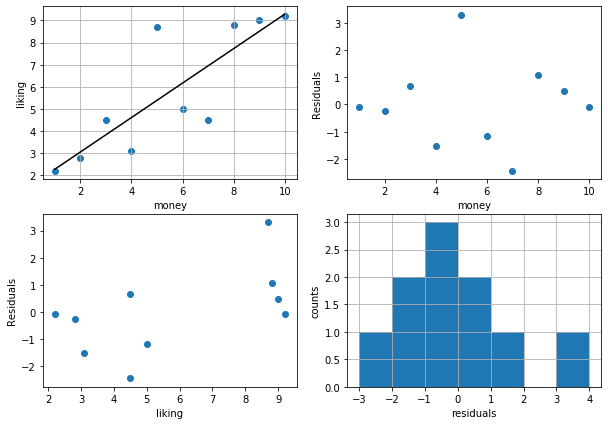

In [48]:
import matplotlib.pyplot as plt

residuals = results.resid
fig, axes=plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
axes[0, 0].scatter(money, liking)
axes[0, 0].plot(money, money*slope+intercept, 'k-')
axes[0, 0].set(xlabel='money', ylabel='liking')
axes[0, 0].grid()
axes[0, 1].scatter(money, residuals)
axes[0, 1].set(xlabel='money', ylabel='Residuals')
axes[1, 0].scatter(liking, residuals)
axes[1, 0].set(xlabel='liking', ylabel='Residuals')
axes[1, 1].hist(residuals, align='mid', bins=[-3,-2,-1,0,1,2,3,4])
axes[1, 1].set(xlabel='residuals', ylabel='counts')
axes[1, 1].grid()

plt.show()

You can see from the plots that while the residuals seem fairly even on the 'money' plot, there is a slight pattern in the 'liking' plot, such that residuals seem to be larger at higher levels of liking, and lower at lower levels of liking. This pattern suggests that our data might not entirely meet the assumption of linearity or homoscedasticity.

In the histogram, the residuals take a kind of a pyramid shape, with most of the values around zero, and fewer values as you move away from zero. This means they're normally distributed, except for the one outlier between 3 and 4.

## Making Predictions

If all the assumptions are met and the model is significant, we will be able to make prediction on two levels of intervals:
1.  Prediction Intervals
2.  Confidence Intervals

In [52]:
newdata=[1, 3] #money=3, add the constant=1 manually
results.get_prediction(newdata).summary_frame(alpha = 0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,3.834545,0.703339,2.212643,5.456448,-0.360403,8.029494


The the last cells `obs_ci_lower` and `obs_ci_upper` are the range where true 'liking' score that someone from our **sample** is likingly to give, at 95% of confidence interval.
This means we are 95% sure that if we gave someone from our sample 3 units of money, they would like us somewhere between -0.36 and 8.03. That's quite a wide range.

The middle two cells `mean_ci_lower` and `mean_ci_upper` are the range of scores which our **population** are likely to give.
We're 95% sure that the mean amount that someone would like us if we gave them 3 units of money in the population falls between 2.12 and 5.46. This is quite a bit narrower than the prediction interval.

# Multiple Regression

## Calculation

We add one more predictor `smile` to our above sample to make the multiple regression. Then, we can use [ols](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) function again to get the statistics summary.

In [64]:
smile = np.array([0.6, 0.7, 1.0, 0.1, 0.3, 0.1, 0.4, 0.8, 0.9, 0.2]) #predictor
money  = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) #predictor
liking = np.array([2.2, 2.8, 4.5, 3.1, 8.7, 5.0, 4.5, 8.8, 9.0, 9.2]) #response
df = pd.DataFrame({'smile':smile, 'money': money, 'liking':liking})
#using statsmodel ols function
X=sm.add_constant(df[['smile', 'money']])
model=sm.OLS(df['liking'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 liking   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     8.984
Date:                Thu, 13 Feb 2020   Prob (F-statistic):             0.0117
Time:                        16:18:42   Log-Likelihood:                -17.735
No. Observations:                  10   AIC:                             41.47
Df Residuals:                       7   BIC:                             42.38
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6162      1.545      0.399      0.7

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


R squared for our model is 0.72 - this means that our model including money and smiling is about 72% better than just using the mean to predict how much someone will like us.

F-statistic is 8.984, where p = 0.0117. Based on this, if all of our assumptions are met, smiling and/or money significantly predict liking. Next, we can check the individual parameters in the model. When controling for smiling, liking is related to money. For every unit increase in money, liking increases by 0.8008. The lower limit at 2.5% is 0.3353, and upper limit at 97.5% is 1.249. If we want to change the confidence level 90%, we can calculate the interval directly.

In [73]:
lb = 0.8008 - st.t.ppf(0.95, 7) * 0.189 #0.95 the upper tail, two sided, degree of freedom: n-k where k is the number of parameters in the model including intercept.
ub = 0.8008 + st.t.ppf(0.95, 7) * 0.189
print(f'lower bound {lb}\n upper bound {ub} at 90% of confidence level.')

lower bound 0.4427246436434133
 upper bound 1.1588753563565866 at 90% of confidence level.


## checking assumptions

1.   **Linearity**. The assumption of linearity says that the predictors should be linearly related to the response variable. As we cannot really do this when we have more than one predictor, we are going to look at the residuals against the response variable. We would hope to see the residuals move in a straight line.
2.   **Homoscedasticity**. To check this we should make sure the variation in residuals is roughly even at all levels of the predictor.
3.   **Independent errors**
4.   **Sufficient observations**
5.   **Absence of outliers**. Can use the standardized residuals to check. Standardized residuals greater than 3 or less than -3 are likely outliers.
6.   **Residuals normality**

[]

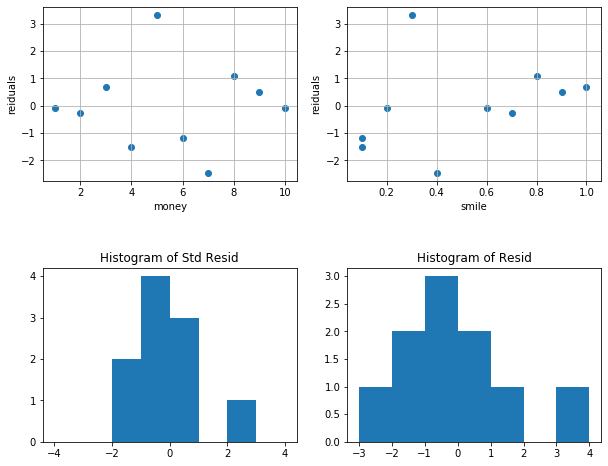

In [94]:
import matplotlib.pyplot as plt

residulas = model.resid
stdresid = residuals/np.std(residuals)
fig, axes=plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
axes[0, 0].scatter(df['money'], residuals)
axes[0, 0].set(xlabel='money', ylabel='reiduals')
axes[0, 0].grid()
axes[0, 1].scatter(df['smile'], residuals)
axes[0, 1].set(xlabel='smile', ylabel='reiduals')
axes[0, 1].grid()
axes[1, 0].hist(stdresid, bins=[-4, -3, -2, -1, 0, 1, 2, 3, 4])
axes[1, 0].set(title='Histogram of Std Resid')
axes[1, 1].hist(residuals, bins=[-3, -2, -1, 0, 1, 2, 3, 4], align='mid')
axes[1, 1].set(title='Histogram of Resid')
fig.subplots_adjust(wspace=0.2, hspace=0.5)
plt.plot()

We see some values fan out in the middle. That means the assumption of homoscedasticity is violated. The linearity is somewhat problematic because of these outliers. From the standardize residuals histogram, it looks like it has one residual over 2, but nothing over or under 3. From the Residuals histogram, we can tell the residuals follow a fairly normal pattern, however the sneaky outliers from before show up at either tail!

## Categorical predictors

Let's include a variable called talk. We either said something neutral ("Nice weather today"), rude ("You smell"), or polite ("You are great"). We coded these responses as 1, 2, and 3, respectively. As OLS function does not help us to dummify the categorical variable directly, we are using its R style [formula.api](https://www.statsmodels.org/dev/example_formulas.html) to do it, with ols function. You can also use pandas [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) function to generate such dummies, dropping one of its level from each categorical variable, and put it back to OLS function.

In [114]:
import statsmodels.formula.api as smf

talk = np.array([1, 2, 3, 2, 3, 1, 2, 1, 3, 1])
df['talk']=talk
df['talk']=df['talk'].astype('category')
model2 = smf.ols(formula='liking~smile+money+C(talk)', data=df).fit()
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:                 liking   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     8.286
Date:                Thu, 13 Feb 2020   Prob (F-statistic):             0.0197
Time:                        17:21:58   Log-Likelihood:                -13.933
No. Observations:                  10   AIC:                             37.87
Df Residuals:                       5   BIC:                             39.38
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.9694      1.482      1.329   

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


From the coefficient of talk variable, a rude statement(value 2) was negatively related to how much someone liked us, while a polite statement(value 3) was positively related to how much someone liked us.

## Categorical Response (Logistic Regression)

Let's say instead of a continuous measure of liking, we have a binary measure - either someone likes us (1), or they don't (0).

We can see whether we can predict whether someone likes us or not using logistic regression.

In [116]:
df['liking'] = np.array([0, 0, 0, 0, 1, 1, 0, 1, 1, 1])
X = sm.add_constant(df[['smile', 'money']])
model3 = sm.Logit(df['liking'], X).fit()
print(model3.summary())

Optimization terminated successfully.
         Current function value: 0.347148
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 liking   No. Observations:                   10
Model:                          Logit   Df Residuals:                        7
Method:                           MLE   Df Model:                            2
Date:                Thu, 13 Feb 2020   Pseudo R-squ.:                  0.4992
Time:                        17:47:11   Log-Likelihood:                -3.4715
converged:                       True   LL-Null:                       -6.9315
Covariance Type:            nonrobust   LLR p-value:                   0.03143
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.5794      3.276     -1.398      0.162     -11.001       1.842
smile         -1.4755      3.

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


We can tell from the coefficient of money that when you give a person one unit of money, the log odds of them liking you increases by 0.9312. If we take the expopential of log odd, we will get the odd as 2.5, and probability that people like you will be 0.72, which means the increase of 1 unit of money will increase 75% of chance they like you more.

In [119]:
odds = np.exp(0.9312)
py = odds/(1+odds)
py

0.7173186760473905

# Quantitative associations: ANOVA

In [0]:
# ANNOVA